In [1]:
!wget http://www.soshnikov.com/permanent/data/petfaces.tar.gz
!tar xfz petfaces.tar.gz
!rm petfaces.tar.gz

--2025-04-20 11:54:47--  http://www.soshnikov.com/permanent/data/petfaces.tar.gz
Resolving www.soshnikov.com (www.soshnikov.com)... 79.137.227.122
Connecting to www.soshnikov.com (www.soshnikov.com)|79.137.227.122|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24483412 (23M) [application/x-tar]
Saving to: ‘petfaces.tar.gz’

petfaces.tar.gz     100%[===================>]  23.35M   773KB/s    in 32s     

2025-04-20 11:55:19 (750 KB/s) - ‘petfaces.tar.gz’ saved [24483412/24483412]



In [2]:
import pickle
import numpy as np
import torch
import torch.nn as nn

from skimage import io
from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader

from matplotlib import colors, pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [3]:
DATA_MODES = ['train', 'val', 'test']
RESCALE_SIZE = 224

DEVICE = torch.device("cuda")
if torch.cuda.is_available:
  print("cuda")
else: print("cpu")

cuda


Опишем свой класса датасета для работы с изображениями

In [5]:
class PetFacesDataset(Dataset):
    def __init__(self, files, mode, task="bin"):
        super().__init__()
        self.files = sorted(files)
        self.mode = mode
        self.task = task

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            if self.task == "bin":
                self.labels = [path.parent.name[0:3] for path in self.files]
                self.label_encoder.fit(self.labels)
                with open('label_encoder.pkl', 'wb') as le_dump_file:
                    pickle.dump(self.label_encoder, le_dump_file)

            else:
                self.labels = [path.parent.name for path in self.files]
                self.label_encoder.fit(self.labels)
                with open('label_encoder.pkl', 'wb') as le_dump_file:
                    pickle.dump(self.label_encoder, le_dump_file)


    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [7]:
DIR = Path('petfaces')
task = "bin"
files = sorted(list(DIR.rglob('*.jpg')))

In [8]:
from sklearn.model_selection import train_test_split

y = [path.parent.name[0:3] for path in files]

train_data, test_data = train_test_split(files, train_size=0.8, stratify=y)

In [9]:
train_dataset = PetFacesDataset(train_data, "train")
test_dataset = PetFacesDataset(test_data, "val")

In [10]:
class NetWork(nn.Module):
  def __init__(self):
    super(NetWork, self).__init__()
    self.conv1 = nn.Conv2d(3, 6, 3)
    self.pool1 = nn.MaxPool2d(kernel_size=2)
    self.conv2 = nn.Conv2d(6, 12, 3)
    self.pool2 = nn.MaxPool2d(kernel_size=2)
    self.conv3 = nn.Conv2d(12, 24, 3)
    self.pool3 = nn.MaxPool2d(kernel_size=2)
    self.conv4 = nn.Conv2d(24, 90, 7)
    self.pool4 = nn.MaxPool2d(kernel_size=2)
    self.fl = nn.Flatten()
    self.fc1 = nn.Linear(100 * 90, 128)
    self.activation1 = nn.LeakyReLU()
    self.fc2 = nn.Linear(128, 128)
    self.activation2 = nn.ELU()
    self.fc3 = nn.Linear(128, 2)

  def forward(self, x):
    x = self.pool1(self.conv1(x))
    x = self.pool2(self.conv2(x))
    x = self.pool3(self.conv3(x))
    x = self.pool4(self.conv4(x))
    x = self.fl(x)
    x = self.activation1(self.fc1(x))
    x = self.activation2(self.fc2(x))
    x = self.fc3(x)
    return x

model = NetWork()
model = model.to(DEVICE)


Опишем функции для обучения и тестирования модели

In [11]:
def fit_epoch(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [26]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    running_corrects_top3 = 0
    processed_size = 0
    predictions = []
    answers = []
    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

            # Вычисляем top-3 accuracy
            _, top3_preds = torch.topk(outputs, k=3, dim=1)
            correct_top3 = torch.sum(top3_preds == labels.view(-1, 1), dim=1).sum()
            running_corrects_top3 += correct_top3

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        for pred in preds:
            predictions.append(int(pred))
        for label in labels.data:
            answers.append(int(label))
        processed_size += inputs.size(0)

    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    val_acc_top3 = running_corrects_top3.double() / processed_size

    return val_loss, val_acc, val_acc_top3, predictions, answers

In [27]:
def train(train_dataset, test_dataset, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    history = []
    predictions = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f} val_acc_top3 {v_acc_top3:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters())
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            val_loss, val_acc, val_acc_top3, predictions, answers = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc, val_acc_top3))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,
                                           v_loss=val_loss, t_acc=train_acc,
                                           v_acc=val_acc, v_acc_top3=val_acc_top3))

    return history, predictions, answers

In [28]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

Бинарная классификация


In [29]:
history, predictions, answers = train(train_dataset, test_dataset, model=model, epochs=10, batch_size=64)

epoch:  10%|█         | 1/10 [00:12<01:49, 12.19s/it]


Epoch 001 train_loss: 0.9106     val_loss 0.1633 train_acc 0.8711 val_acc 0.9378 val_acc_top3 1.0000


epoch:  20%|██        | 2/10 [00:24<01:39, 12.48s/it]


Epoch 002 train_loss: 0.0584     val_loss 0.1466 train_acc 0.9817 val_acc 0.9502 val_acc_top3 1.0000


epoch:  30%|███       | 3/10 [00:37<01:27, 12.50s/it]


Epoch 003 train_loss: 0.0183     val_loss 0.1677 train_acc 0.9942 val_acc 0.9456 val_acc_top3 0.9984


epoch:  40%|████      | 4/10 [00:49<01:14, 12.48s/it]


Epoch 004 train_loss: 0.0053     val_loss 0.1486 train_acc 0.9992 val_acc 0.9565 val_acc_top3 0.9984


epoch:  50%|█████     | 5/10 [01:01<01:01, 12.36s/it]


Epoch 005 train_loss: 0.0016     val_loss 0.1369 train_acc 1.0000 val_acc 0.9611 val_acc_top3 0.9984


epoch:  60%|██████    | 6/10 [01:14<00:49, 12.26s/it]


Epoch 006 train_loss: 0.0006     val_loss 0.1378 train_acc 1.0000 val_acc 0.9611 val_acc_top3 0.9984


epoch:  70%|███████   | 7/10 [01:26<00:36, 12.22s/it]


Epoch 007 train_loss: 0.0004     val_loss 0.1393 train_acc 1.0000 val_acc 0.9611 val_acc_top3 0.9984


epoch:  80%|████████  | 8/10 [01:38<00:24, 12.26s/it]


Epoch 008 train_loss: 0.0003     val_loss 0.1427 train_acc 1.0000 val_acc 0.9611 val_acc_top3 0.9984


epoch:  90%|█████████ | 9/10 [01:50<00:12, 12.22s/it]


Epoch 009 train_loss: 0.0002     val_loss 0.1451 train_acc 1.0000 val_acc 0.9611 val_acc_top3 0.9984


epoch: 100%|██████████| 10/10 [02:02<00:00, 12.28s/it]


Epoch 010 train_loss: 0.0002     val_loss 0.1469 train_acc 1.0000 val_acc 0.9611 val_acc_top3 0.9984


In [30]:
loss, acc, val_loss, val_acc, val_acc_top3 = zip(*history)

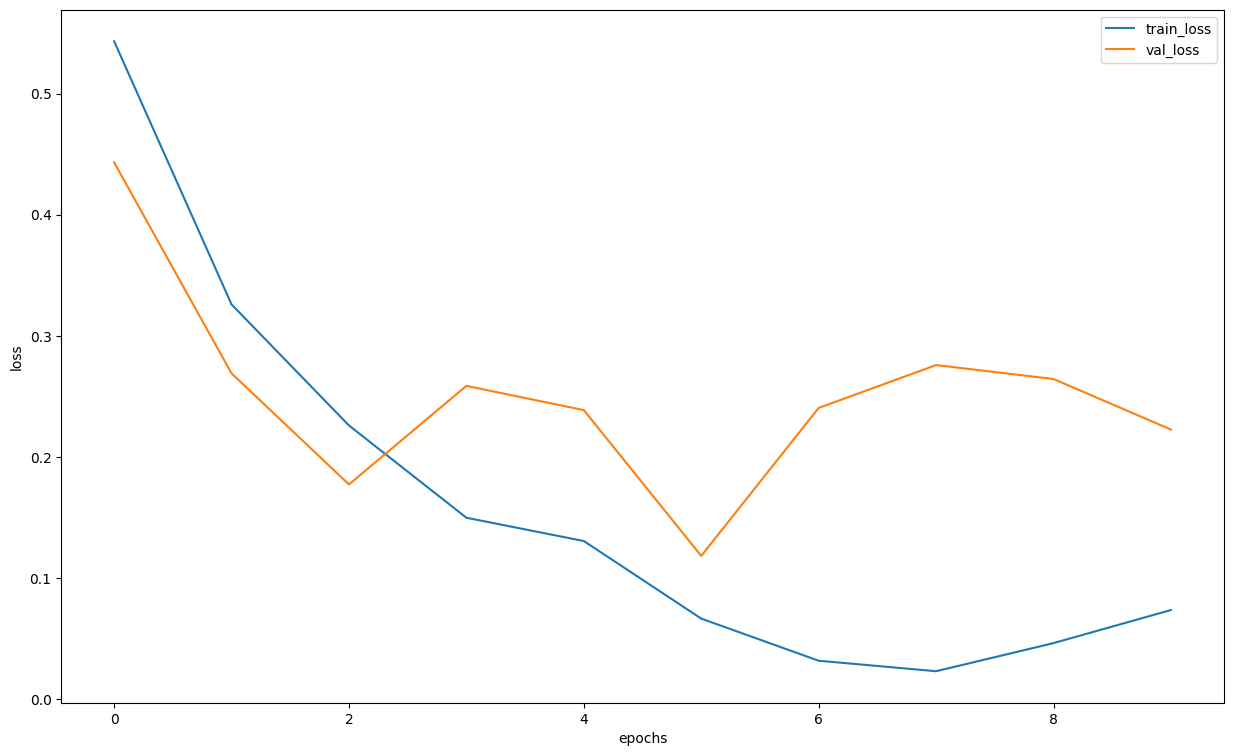

In [17]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

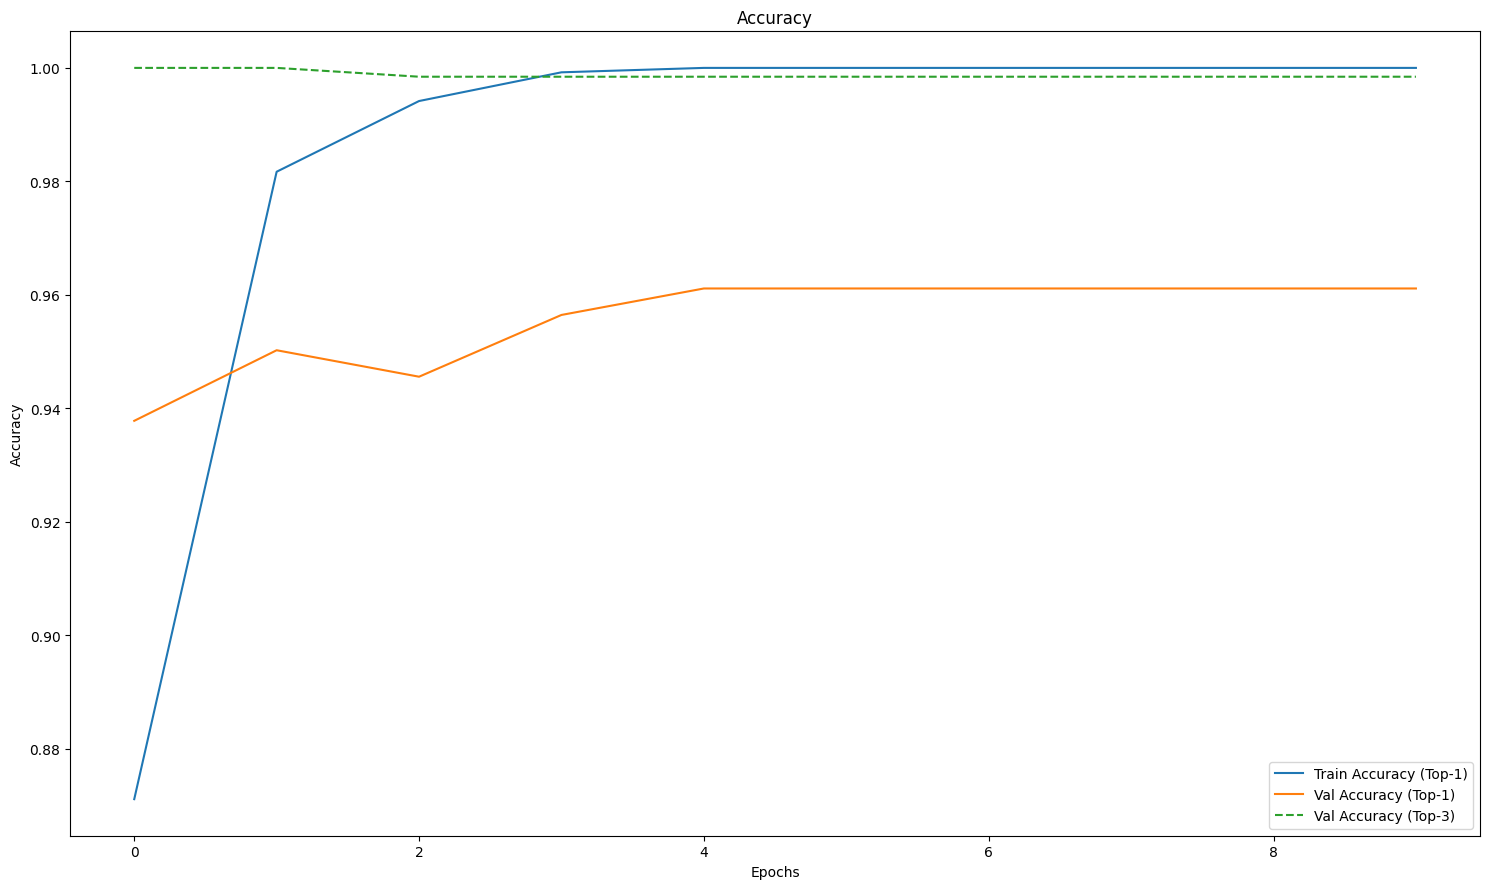

In [32]:
acc = [x.item() if torch.is_tensor(x) else x for x in acc]
val_acc = [x.item() if torch.is_tensor(x) else x for x in val_acc]
val_acc_top3 = [x.item() if torch.is_tensor(x) else x for x in val_acc_top3]

plt.figure(figsize=(15, 9))
plt.plot(acc, label='Train Accuracy (Top-1)')
plt.plot(val_acc, label='Val Accuracy (Top-1)')
plt.plot(val_acc_top3, label='Val Accuracy (Top-3)', linestyle='--')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## Многоклассовая классификация

In [33]:
from sklearn.model_selection import train_test_split

_y = [path.parent.name for path in files]
train_data_multi, test_data_multi = train_test_split(files, train_size=0.8, stratify=_y)

train_dataset_multi = PetFacesDataset(train_data_multi, "train", task="multi")
test_dataset_multi = PetFacesDataset(test_data_multi, "val", task="multi")

In [19]:
model.fc3 = nn.Linear(128, 35)
model = model.to(DEVICE)

In [34]:
history_, predictions_, answers_ = train(train_dataset_multi, test_dataset_multi, model=model, epochs=10, batch_size=128)

epoch:  10%|█         | 1/10 [00:12<01:50, 12.25s/it]


Epoch 001 train_loss: 5.6419     val_loss 3.1819 train_acc 0.0767 val_acc 0.1275 val_acc_top3 0.2986


epoch:  20%|██        | 2/10 [00:24<01:37, 12.18s/it]


Epoch 002 train_loss: 2.8166     val_loss 2.4244 train_acc 0.2208 val_acc 0.3110 val_acc_top3 0.5552


epoch:  30%|███       | 3/10 [00:36<01:26, 12.35s/it]


Epoch 003 train_loss: 2.0692     val_loss 1.8969 train_acc 0.3925 val_acc 0.4277 val_acc_top3 0.6765


epoch:  40%|████      | 4/10 [00:49<01:13, 12.29s/it]


Epoch 004 train_loss: 1.5205     val_loss 1.6263 train_acc 0.5440 val_acc 0.5148 val_acc_top3 0.7667


epoch:  50%|█████     | 5/10 [01:01<01:01, 12.24s/it]


Epoch 005 train_loss: 1.1765     val_loss 1.4641 train_acc 0.6456 val_acc 0.5537 val_acc_top3 0.8320


epoch:  60%|██████    | 6/10 [01:13<00:49, 12.26s/it]


Epoch 006 train_loss: 0.8186     val_loss 1.4326 train_acc 0.7484 val_acc 0.5630 val_acc_top3 0.8134


epoch:  70%|███████   | 7/10 [01:29<00:40, 13.40s/it]


Epoch 007 train_loss: 0.5527     val_loss 1.4232 train_acc 0.8372 val_acc 0.5894 val_acc_top3 0.8398


epoch:  80%|████████  | 8/10 [01:41<00:26, 13.04s/it]


Epoch 008 train_loss: 0.3008     val_loss 1.5579 train_acc 0.9194 val_acc 0.5956 val_acc_top3 0.8367


epoch:  90%|█████████ | 9/10 [01:53<00:12, 12.77s/it]


Epoch 009 train_loss: 0.1526     val_loss 1.6970 train_acc 0.9669 val_acc 0.5816 val_acc_top3 0.8243


epoch: 100%|██████████| 10/10 [02:05<00:00, 12.60s/it]


Epoch 010 train_loss: 0.0806     val_loss 1.8148 train_acc 0.9871 val_acc 0.5848 val_acc_top3 0.8414


In [35]:
loss, acc, val_loss, val_acc, val_acc_top3 = zip(*history_)

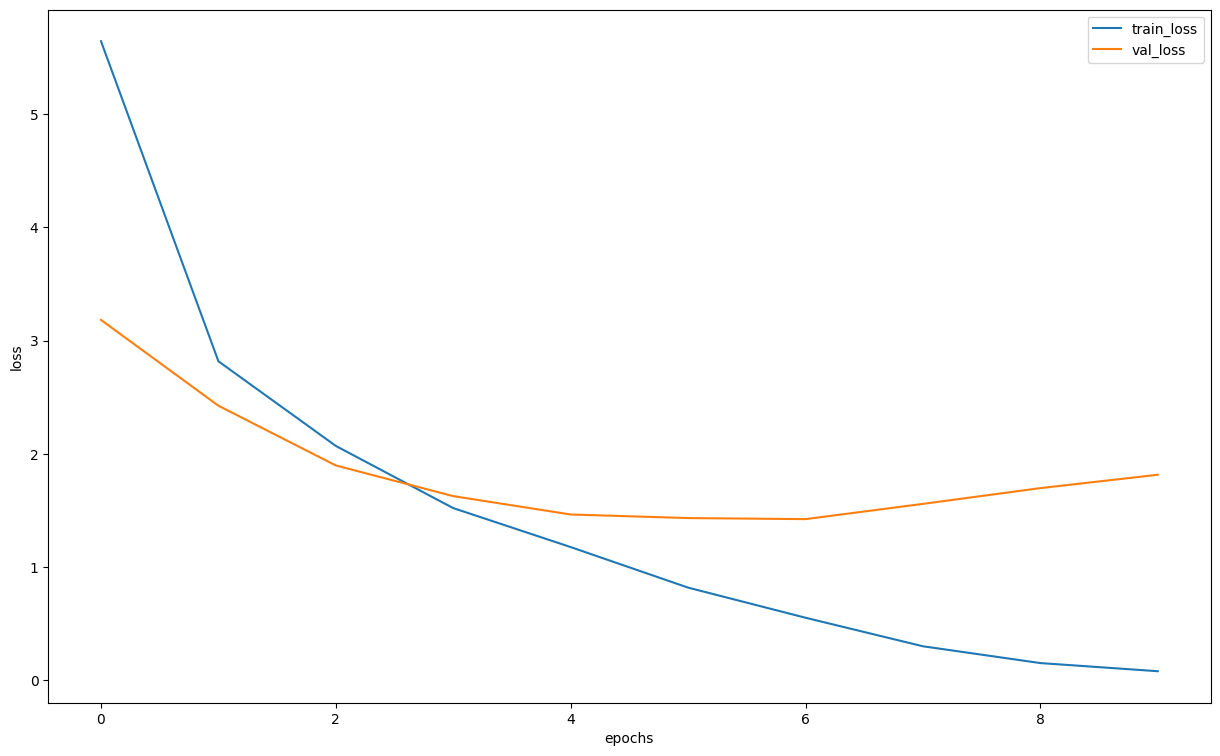

In [36]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

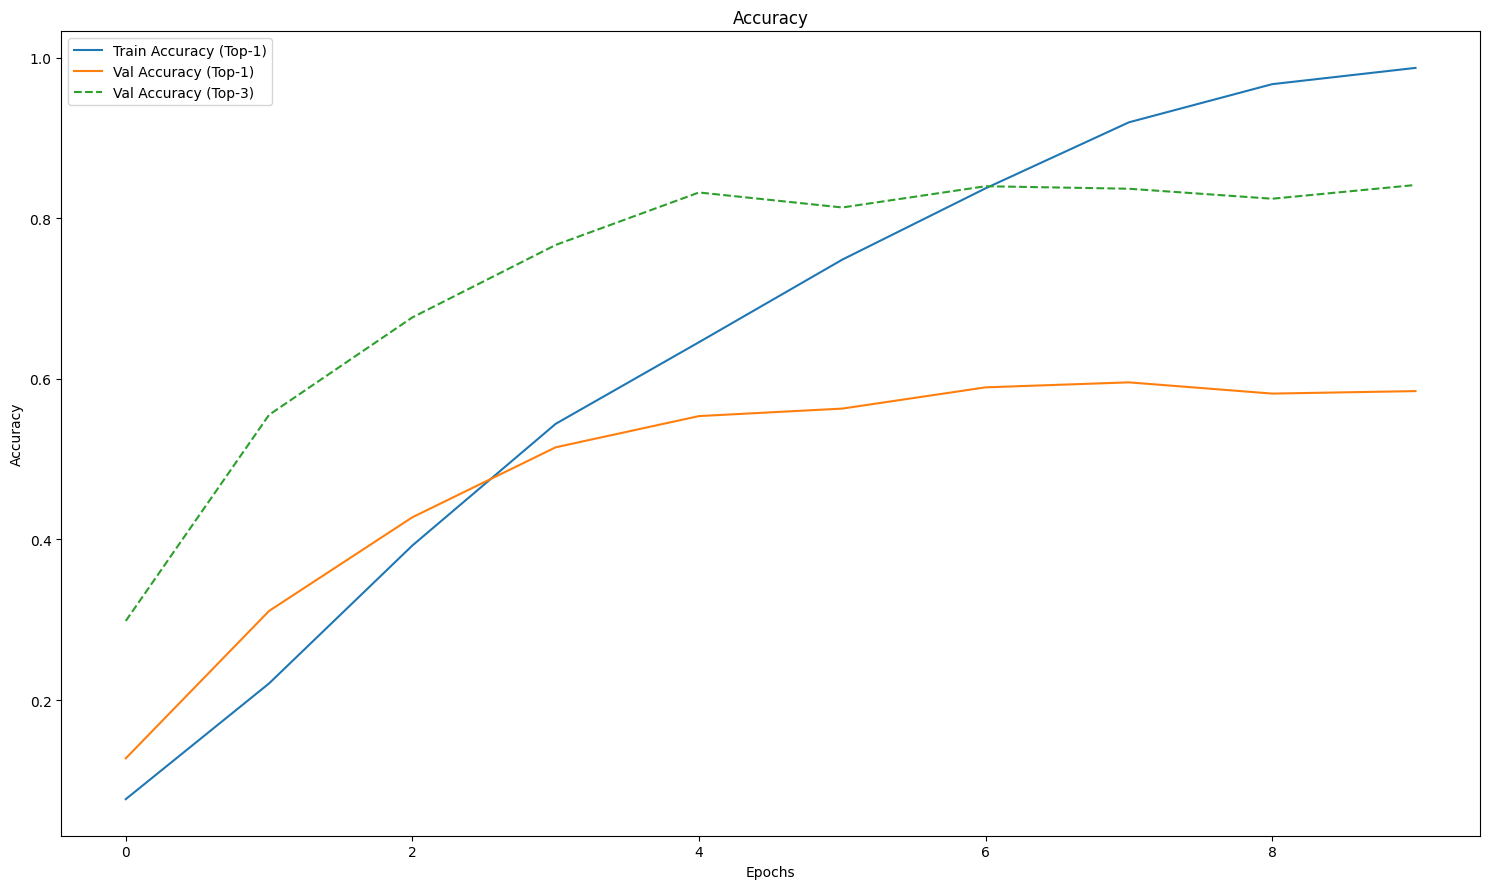

In [37]:
acc = [x.item() if torch.is_tensor(x) else x for x in acc]
val_acc = [x.item() if torch.is_tensor(x) else x for x in val_acc]
val_acc_top3 = [x.item() if torch.is_tensor(x) else x for x in val_acc_top3]

plt.figure(figsize=(15, 9))
plt.plot(acc, label='Train Accuracy (Top-1)')
plt.plot(val_acc, label='Val Accuracy (Top-1)')
plt.plot(val_acc_top3, label='Val Accuracy (Top-3)', linestyle='--')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Построим матрицу ошибок










In [39]:
import numpy as np

classes = list(np.unique(_y))
from sklearn.metrics import confusion_matrix
import pandas as pd

In [40]:
conf_mat = confusion_matrix(answers_, predictions_)
df_cm = pd.DataFrame(conf_mat, index=classes, columns=classes)
df_cm

,cat_Abyssinian,cat_Bengal,cat_Birman,cat_Bombay,cat_British,cat_Egyptian,cat_Maine,cat_Persian,cat_Ragdoll,cat_Russian,...,dog_newfoundland,dog_pomeranian,dog_pug,dog_saint,dog_samoyed,dog_scottish,dog_shiba,dog_staffordshire,dog_wheaten,dog_yorkshire
cat_Abyssinian,10,3,0,0,0,0,3,0,0,0,...,0,0,0,0,0,0,0,0,0,0
cat_Bengal,4,5,0,0,0,2,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
cat_Birman,0,0,14,0,0,0,0,0,2,0,...,0,0,0,0,0,0,0,0,0,0
cat_Bombay,0,0,0,14,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
cat_British,0,0,0,0,13,0,1,1,0,5,...,0,0,0,0,0,0,0,0,0,0
cat_Egyptian,1,2,0,0,1,8,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
cat_Maine,0,2,0,0,1,0,15,0,0,1,...,0,0,0,0,0,0,0,0,0,0
cat_Persian,0,0,0,0,0,0,2,17,0,0,...,0,0,0,0,0,0,0,0,0,0
cat_Ragdoll,0,1,2,0,0,0,2,2,9,0,...,0,1,0,1,0,0,0,0,0,0
cat_Russian,0,0,1,0,2,0,0,0,0,14,...,0,0,0,0,0,1,0,0,0,0
